In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import pandas as pd
import sciplots as plots
from netloader import transforms
from netloader.data import loader_init

from src.utils import data, analysis
from src.utils.utils import open_config

reload(data)
reload(analysis)
from src.utils.data import DarkDataset
from src.utils import analysis, plot_config

In [40]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0008E0', '#004FE0', '#0097E0', '#00DCE0']
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA2100', '#FA7700']
flamingo_test = ['#FA07A0']
# colours = ['k'] + flamingo_colours + bahamas_agn_colours + bahamas_colours
colours = ['k'] + plot_config.BAHAMAS
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)

In [70]:
data = analysis.batch_train_summary(25, '../data/', 'batch_train')
nets = data['nets']

In [34]:
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm',
        # 'bahamas_cdm_low',
        # 'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        # 'flamingo_low',
        # 'flamingo_hi',
        # 'flamingo',
    ],
    ['noise'],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()

In [ ]:
with open('../data/temp_batch_predictions_25.pkl', 'rb') as file:
    predictions = pickle.load(file).tolist()

In [36]:
torch.manual_seed(0)
np.random.seed(0)
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    nets[:, 1],
    dataset,
)

Loader Dataset Lengths: [12320, 3080]
Prediction time: 1.055e+00 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.955e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.349e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 1.048e+00 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 9.400e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.907e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.371e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.369e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.164e-01 s
Loader Dataset Lengths: [12320, 3080]
Prediction time: 8.337e-01 s


In [106]:
with open('../data/temp_batch_predictions_25.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [61]:
for shape in np.ndindex(predictions.shape):
    predictions[*shape]['latent'] = nets[:, 0][*shape].transforms['targets'][1:](predictions[*shape]['preds'])

In [62]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    data['nets'][:, 1],
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((1, 10, 5), (1, 5, 500), (1, 500), (1, 5, 500), (7, 1, 5))

In [102]:
idxs = data_pred['targets'][0, 0, 0, :, 0] == np.unique(data_pred['targets'][0, 0, 0, :, 0])[-1]
np.mean(data['nets'][0, 0, 0].transforms['targets'](data_pred['preds'][0, 0, 0, idxs, 0], back=True)), data['nets'][0, 0, 0].transforms['targets'](np.mean(data_pred['preds'][0, 0, 0, idxs, 0]), back=True), np.median(data['nets'][0, 0, 0].transforms['targets'](data_pred['preds'][0, 0, 0, idxs, 0], back=True))

(np.float64(0.74465216158222),
 array([0.554338]),
 np.float64(0.7358715783237253))

[Architecture: Encoder
 Description: Log, NX, 1L, Noise, Regression, Noise
 Version: <3.7.1
 Network: network_v10_encoder
 Epoch: 150
 Optimiser: AdamW
 Scheduler: ReduceLROnPlateau
 Args: (loss_func: MSELoss)
 Architecture: Encoder
 Description: Log, NX, 1L, Noise, Regression, Noise
 Version: <3.7.1
 Network: network_v10_encoder
 Epoch: 150
 Optimiser: AdamW
 Scheduler: ReduceLROnPlateau
 Args: (loss_func: MSELoss)
 Architecture: Encoder
 Description: Log, NX, 1L, Noise, Regression, Noise
 Version: <3.7.1
 Network: network_v10_encoder
 Epoch: 150
 Optimiser: AdamW
 Scheduler: ReduceLROnPlateau
 Args: (loss_func: MSELoss)
 Architecture: Encoder
 Description: Log, NX, 1L, Noise, Regression, Noise
 Version: <3.7.1
 Network: network_v10_encoder
 Epoch: 150
 Optimiser: AdamW
 Scheduler: ReduceLROnPlateau
 Args: (loss_func: MSELoss)
 Architecture: Encoder
 Description: Log, NX, 1L, Noise, Regression, Noise
 Version: <3.7.1
 Network: network_v10_encoder
 Epoch: 150
 Optimiser: AdamW
 Schedul

,50%,5%,16%,84%,95%,-,+
Noise,0.58898,0.50027,0.52825,0.65669,0.70291,0.06073,0.06771
BAHAMAS-0,0.02131,0.01646,0.01810,0.02543,0.02914,0.00321,0.00412
BAHAMAS-0.1,0.05992,0.03119,0.03773,0.12836,0.19569,0.02219,0.06844
BAHAMAS-0.3,0.36093,0.23674,0.28641,0.43664,0.48684,0.07452,0.07572
BAHAMAS-1,0.64782,0.50712,0.56543,0.75238,0.81637,0.08239,0.10456


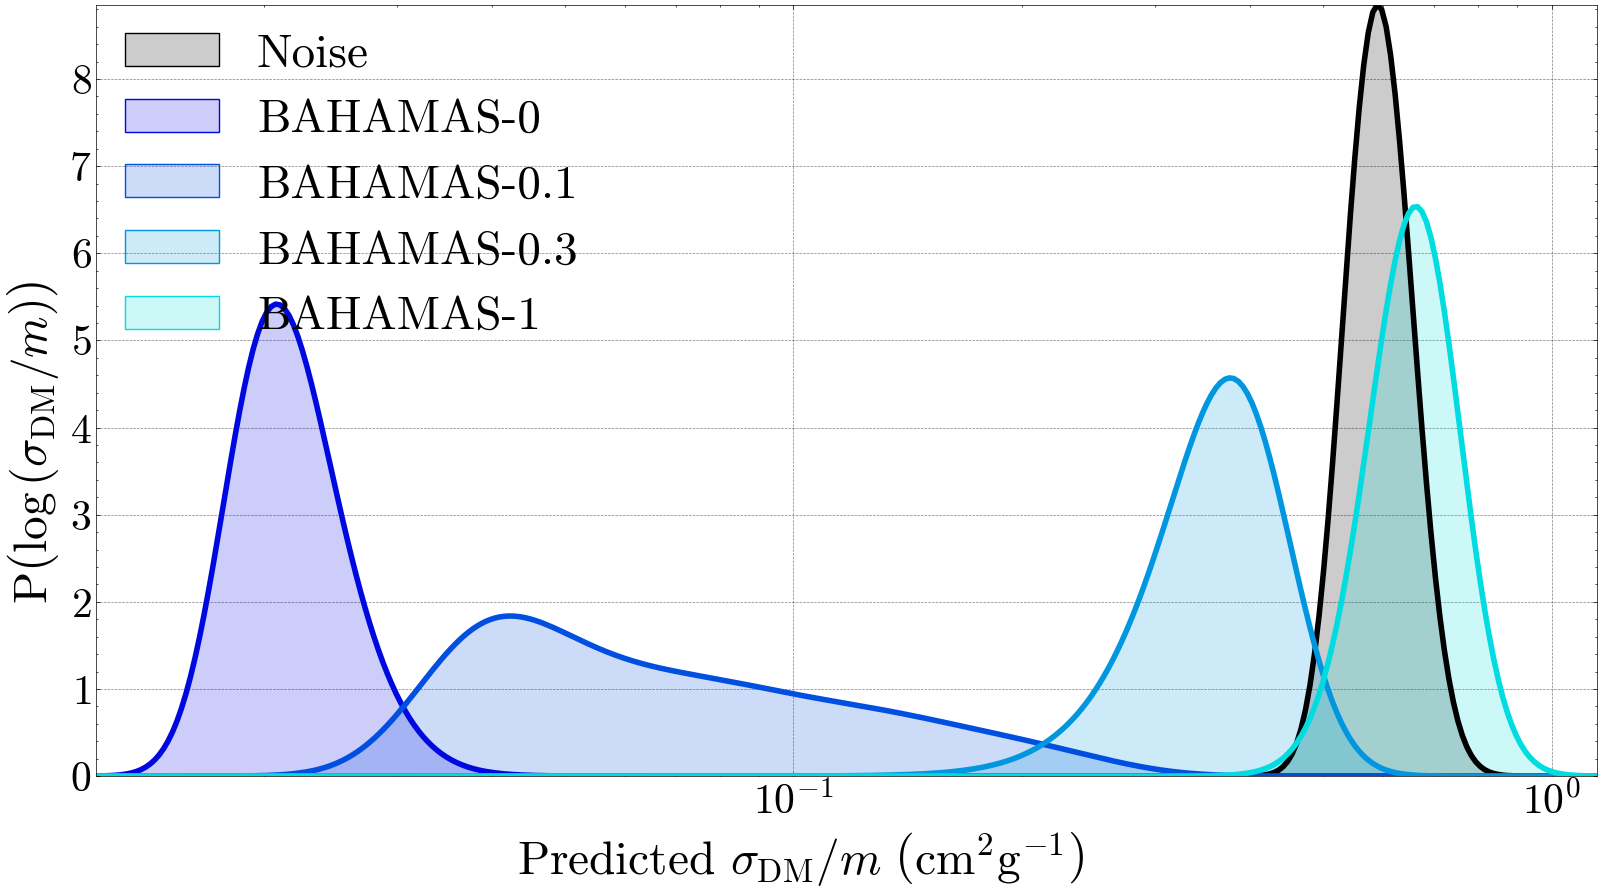

In [71]:
idx = (0,)
styles = np.array(['-'] * len(labels), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels.copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    # label_permute=[0, 1, 3, 2],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
print(nets[*idx, 0])
pd.DataFrame(quantiles[:, *idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

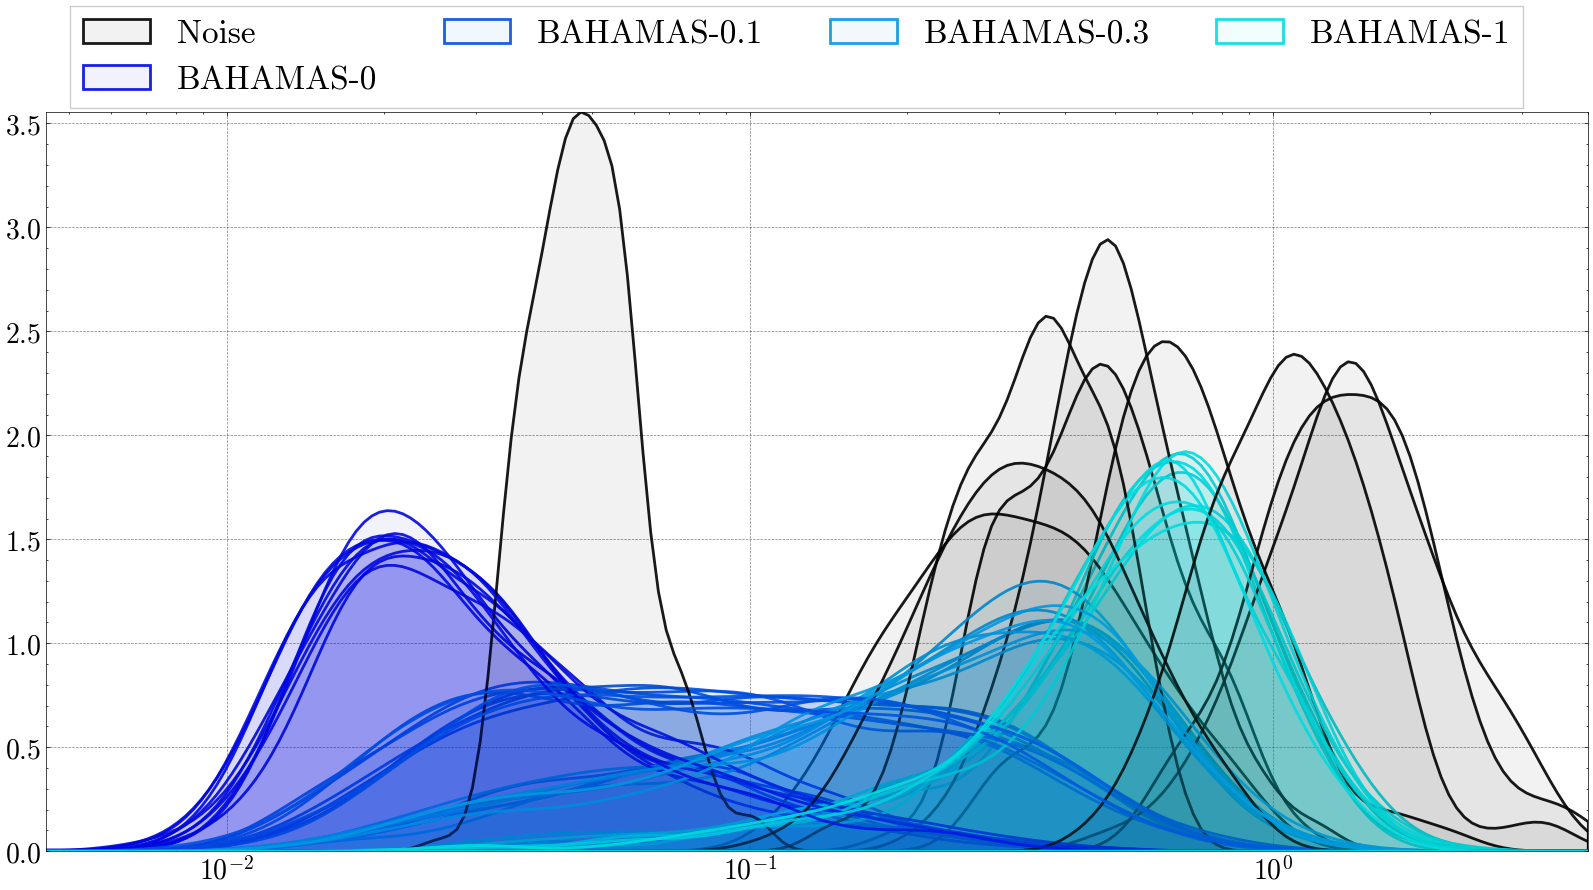

In [68]:
data_idxs = [0, -4, -3, -2, -1]
idx = (0,)
plot = plots.PlotDistribution(
    # [distributions[-1, 0, 0]],
    data['nets'][*idx, 1, 0].transforms['targets'](distributions[*idx][:, data_idxs].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(np.array(colours)[data_idxs], distributions.shape[-2]).tolist(),
    # colours=colours,
    bins=200,
    labels=np.tile(labels[data_idxs], distributions.shape[-2]).tolist(),
    alpha_2d=0.05,
    # fig_size=(8,4),
)

In [ ]:
for line, poly in zip(plot.plots[plot.axes][::2], plot.plots[plot.axes][1::2]):
    line.remove()
    poly.remove()
    plot.plots[plot.axes].remove(line)
    plot.plots[plot.axes].remove(poly)

    line.set_ydata(line.get_ydata() / np.sum(line.get_ydata()))
    verts = poly.get_paths()[0].vertices
    verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
    poly.set_verts([verts])

    plot.axes.add_line(line)
    plot.axes.add_collection(poly)
    plot.plots[plot.axes].append(line)
    plot.plots[plot.axes].append(poly)

plot.set_axes_pad()

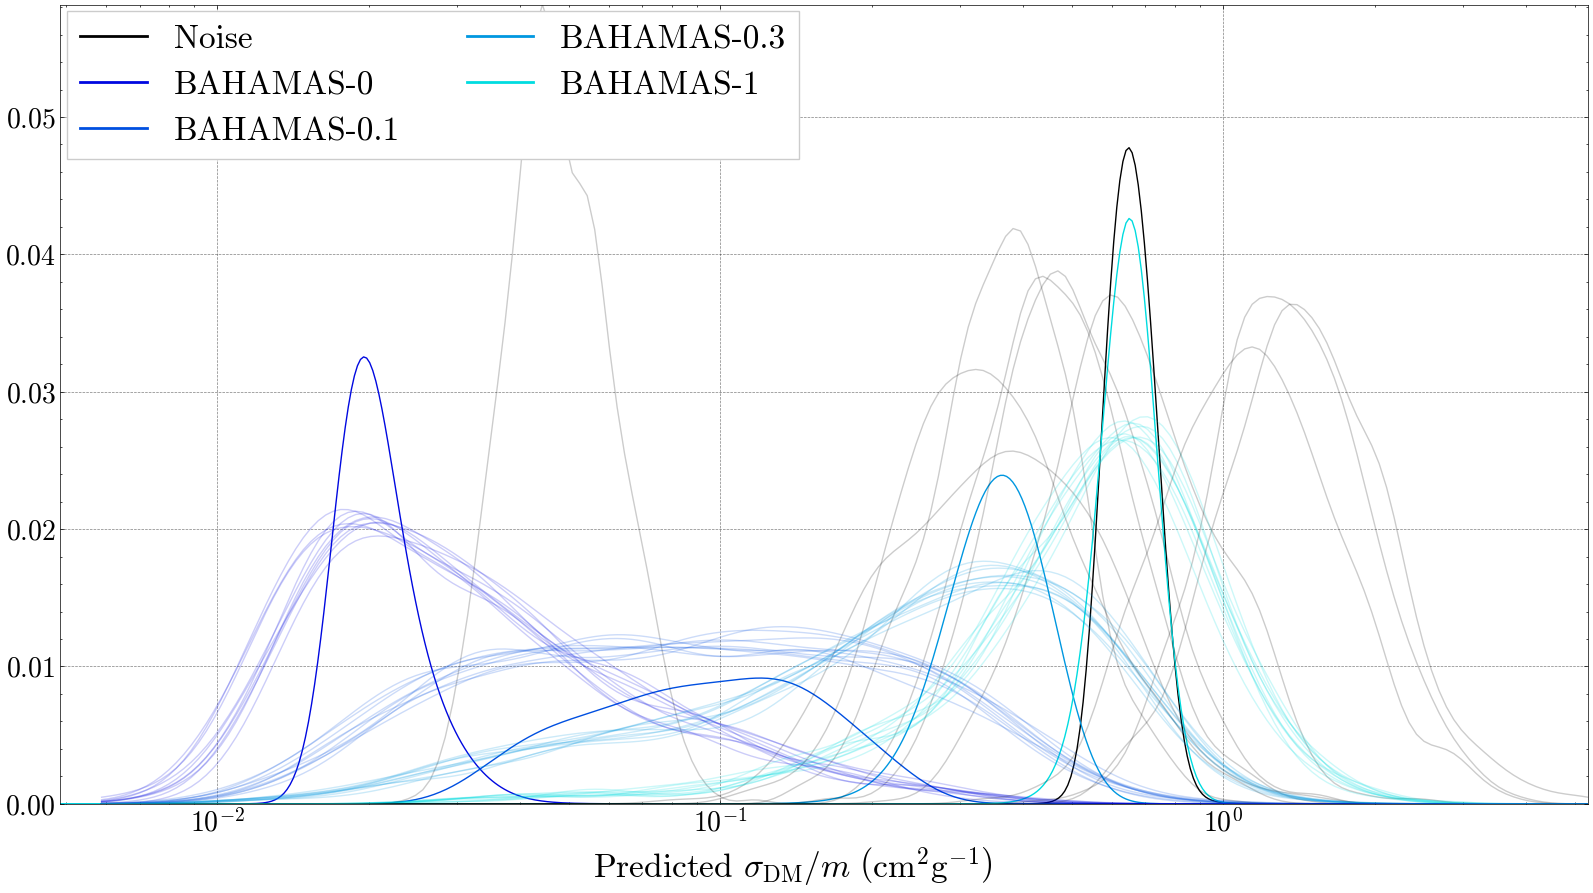

In [140]:
for line, poly in zip(plot.plots[plot.axes][::2], plot.plots[plot.axes][1::2]):
    plot2.plots[plot2.axes].append(plot2.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.2)[0])
    # plot2.plots[plot2.axes].append(poly)
    # plot2.axes.add_line(line)
    # plot2.axes.add_collection(poly)

plot2.set_axes_pad()
plot2.fig

(np.float64(0.012641369981139497), np.float64(0.9891628089955289))

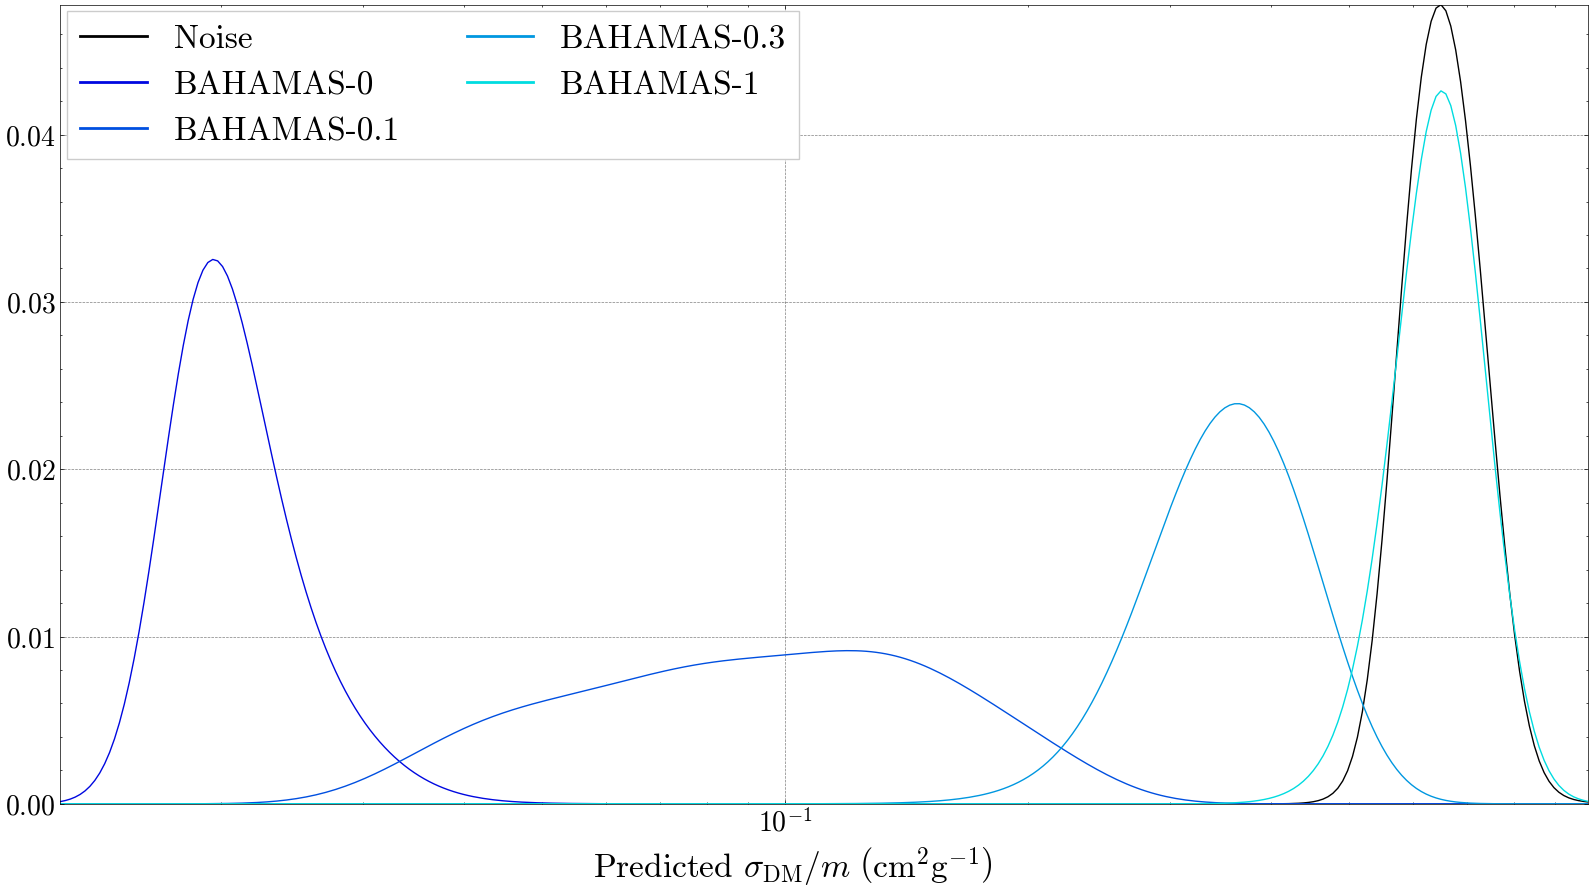

In [133]:
idx = (-1, 1)
plot2 = plots.PlotPlots(
    data['nets'][*idx, 0].transforms['targets'](grids[*idx], back=True),
    probs[*idx, data_idxs],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    markers='',
    labels=labels[data_idxs].tolist(),
    colours=np.array(colours)[data_idxs].tolist(),
    axis=True,
    loc='upper left',
    cols=2,
    # fig_size=(8,4),
)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-4)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-4)]))

In [142]:
quantiles[0, -1, 1, 0] - quantiles[2, -1, 1, 0], quantiles[3, -1, 1, 0] - quantiles[0, -1, 1, 0]

(np.float64(0.06891223909510524), np.float64(0.07709089337836439))

In [141]:
idx = (-1, 1)
pd.DataFrame(quantiles[:, *idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in quantile_values]).round(5)

,50%,5%,16%,84%,95%
Noise,0.64956,0.54134,0.58065,0.72665,0.77941
FLAMINGO Low,0.03469,0.02184,0.02478,0.08157,0.12956
FLAMINGO High,0.03057,0.02154,0.02443,0.04994,0.11745
FLAMINGO,0.03234,0.02094,0.02409,0.05282,0.09652
BAHAMAS-0 Low,0.02154,0.01673,0.01846,0.02513,0.02772
BAHAMAS-0 High,0.02215,0.01604,0.01820,0.02733,0.03144
BAHAMAS-0,0.02036,0.01582,0.01721,0.02478,0.02973
BAHAMAS-0.1,0.09254,0.03669,0.04994,0.15988,0.20867
BAHAMAS-0.3,0.35053,0.23344,0.27620,0.43868,0.49767
BAHAMAS-1,0.64051,0.50469,0.55673,0.72665,0.79041


In [36]:
distributions = []

for target in np.unique(data_pred['targets'][0, 0, 0, :, 0]):
    idxs = target == data_pred['targets'][0, 0, 0, :, 0]
    distributions.append(data_pred['preds'][0, 0, 0, idxs, 0].flatten())

In [38]:
np.array(distributions).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [37]:
# idxs = [1, 5, 6, 7, 8, 9]
idxs = np.arange(len(distributions))
plot = plots.PlotDistribution(
    np.array(distributions, dtype=object)[idxs],
    log=True,
    norm=True,
    y_axes=False,
    density=True,
    # axis_pad=False,
    bins=400,
    x_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=np.array(labels)[idxs],
    colours=['k'] + bahamas_colours,
)
plot.axes.set_xlim([np.min(data['preds']), np.max(data['preds'])])
plot.axes.set_ylim([0, 1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(0.0, 1.0)

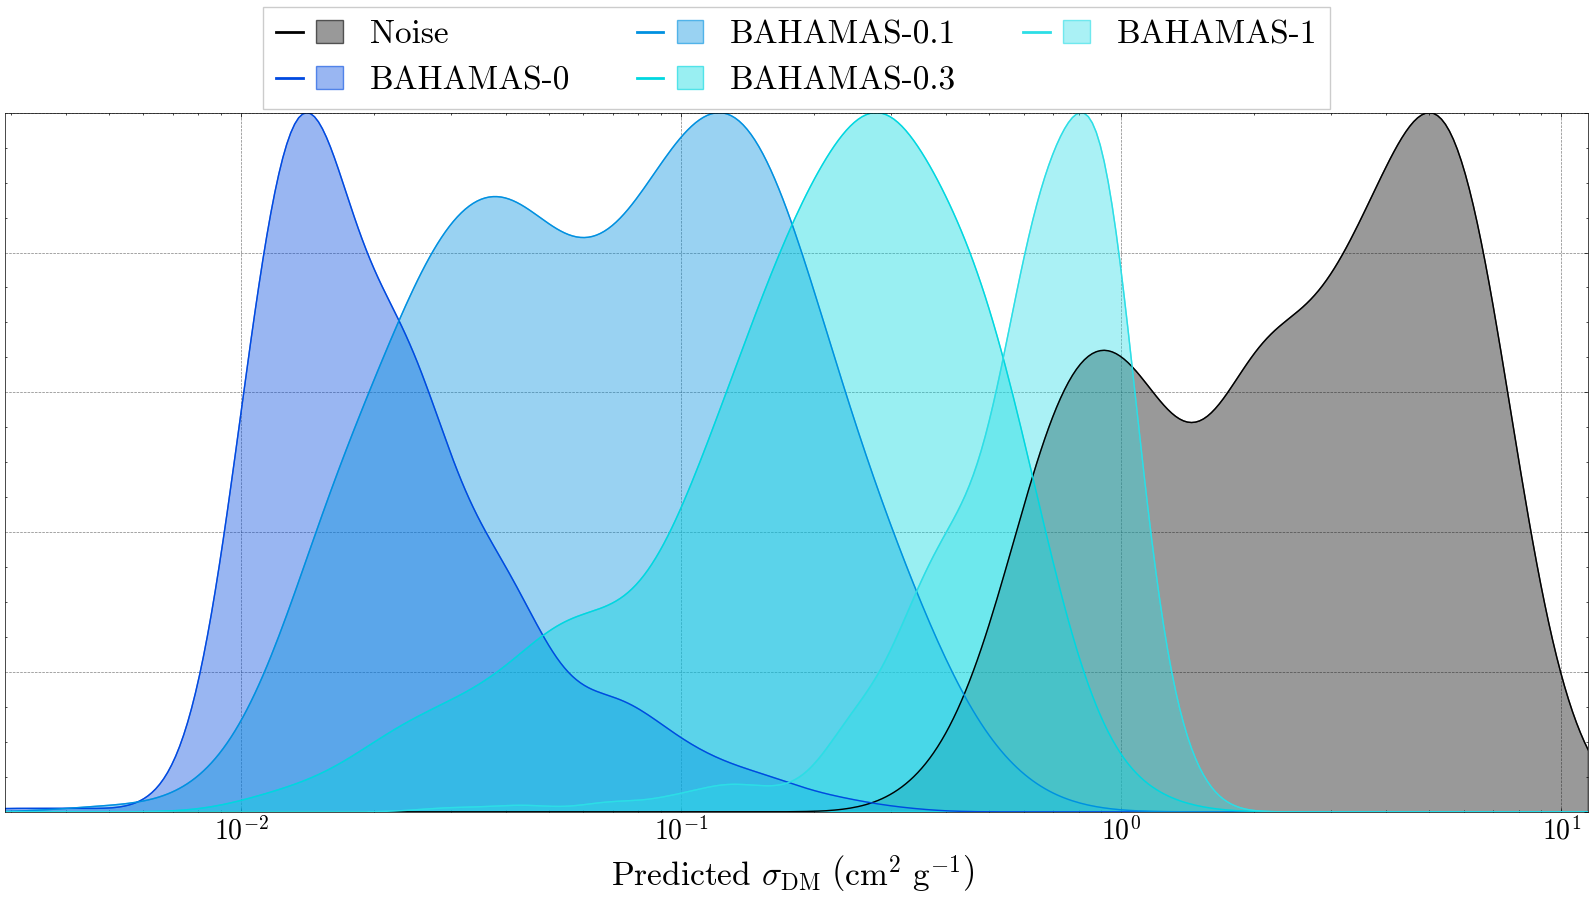

In [19]:
# idxs = [1, 5, 6, 7, 8, 9]
idxs = np.arange(len(distributions))
plot = plots.PlotDistribution(
    np.array(distributions, dtype=object)[idxs],
    log=True,
    norm=True,
    y_axes=False,
    density=True,
    # axis_pad=False,
    bins=400,
    x_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=np.array(labels)[idxs],
    colours=['k'] + bahamas_colours,
)
plot.axes.set_xlim([np.min(data['preds']), np.max(data['preds'])])
plot.axes.set_ylim([0, 1])

In [20]:
plot.savefig('../plots/', name='test')